In [ ]:
# Code borrow insightface inswapper python examples & https://github.com/s0md3v/roop exmaples

# Usage Example for insightface lib
## inswapper - Face swap by one image

insightface toolkit consists of huge face and image processing tool and model zoo for common usage. Here is an example to swap face by one picture.

In [ ]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://github.com/sprint-mammoth/cog-face-alignment/blob/main/notebooks/predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment setup

If running from Google Colab, set `using_colab=True` below and run the cell. GPU is necessary and should be setup in runtime.

In [1]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("GPU:", torch.cuda.get_device_name(0))
        print(torch.version.cuda)

    import sys
    !{sys.executable} -m pip install matplotlib opencv-python onnxruntime-gpu insightface==0.7.3 gfpgan


Download pretrain weight of arcface etc. from insightface

In [ ]:
# Create necessary directories
!mkdir checkpoints
!mkdir -p ~/.insightface/models/buffalo_l/

# Download and extract the buffalo_l model
!wget https://github.com/deepinsight/insightface/releases/download/v0.7/buffalo_l.zip
# !gdown -O buffalo_l.zip https://drive.google.com/uc?id=1qXsQJ8ZT42_xSmWIYy85IcidpiZudOCB
!unzip buffalo_l.zip -d ~/.insightface/models/buffalo_l/
# !sudo rm buffalo_l.zip

# Download GFPGANv1.4
!wget -P checkpoints https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.4.pth
# Download inswapper_128.onnx
!wget -P checkpoints  https://huggingface.co/ashleykleynhans/inswapper/resolve/main/inswapper_128.onnx

# Install gdown and download an test image
!pip install gdown
!gdown -O multifaces.jpg https://drive.google.com/uc?id=1p8_c7YNtK-Xcr51CQxT4POLjjtORnYhR


## Setup

Necessary imports and helper class/functions for swap face, init checkpoints

In [16]:
#import datetime
import numpy as np
#import os
#import os.path as osp
#import glob
import cv2
import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image

In [5]:
# example code from https://github.com/deepinsight/insightface/blob/master/examples/in_swapper/inswapper_main.py

# Check the version of insightface
assert insightface.__version__>='0.7'

# Prepare the Face Analysis app
app = FaceAnalysis(name='buffalo_l')
app.prepare(ctx_id=0, det_size=(640, 640)) # ctx_id=0 means GPU/CUDA support
# Load the face swapper model
swapper = insightface.model_zoo.get_model('./checkpoints/inswapper_128.onnx', download=True, download_zip=True)

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'cudnn_conv_use_max_workspace': '1', 'tunable_op_enable': '0'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '

In [24]:
import gfpgan

face_enhancer = gfpgan.GFPGANer(model_path='./checkpoints/GFPGANv1.4.pth', upscale=1)


## Example image

In [6]:
# Load target image
image_path = 'multifaces.jpg'
# img = Image.open(image_path)
img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

# OpenCV loads images in BGR format by default. We'll convert them to RGB to display them correctly in matplotlib.
# List of source image paths
src_paths = ["model1.jpeg", "model2.jpeg", "model3.jpeg", "model4.jpeg"]
# Load the images using OpenCV and convert to RGB format for display with matplotlib
src_imgs = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in src_paths]


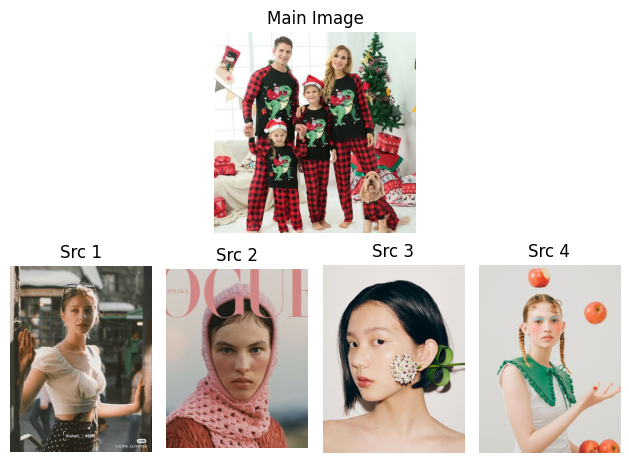

In [21]:
# Display the main image
import matplotlib.pyplot as plt

plt.subplot(2, 1, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Main Image')

# Display the 4 source images
for idx, src_img in enumerate(src_imgs, start=1):
    plt.subplot(2, 4, 4 + idx)
    plt.imshow(src_img)
    plt.axis('off')
    plt.title(f'Src {idx}')

plt.tight_layout()
plt.show()

Detect and swap each face in photo

In [36]:
# example code from https://github.com/deepinsight/insightface/blob/master/examples/in_swapper/inswapper_main.py

def get_face(face_analyser, img_data):
  '''get and return the largest single face in a image'''
  analysed = face_analyser.get(img_data)
  if not analysed:
      print("No face found")
      return None
  largest = max(analysed, key=lambda x: (x.bbox[2] - x.bbox[0]) * (x.bbox[3] - x.bbox[1]))
  return largest

# detect faces positoin from target photo
# img = ins_get_image('multifaces.jpg')
faces = app.get(img)
# faces = sorted(faces, key = lambda x : x.bbox[0])

print(len(faces))

# Process src_imgs to get face representations
src_face_representations = [get_face(app, src_img) for src_img in src_imgs]

# Ensure all source images at least had a face detected
if None in src_face_representations:
    raise ValueError("One or more source images didn't have a face detected.")

# swap each target face with corresponding source face and paste it back to image
# If the number of source images is less than detected faces, we'll loop through the source images.
res = img.copy()
for idx, face in enumerate(faces):
    specific_src_face = src_face_representations[idx % len(src_face_representations)]
    res = swapper.get(res, face, specific_src_face, paste_back=True)

# Convert the result back to BGR for correct saving using OpenCV
res_bgr = cv2.cvtColor(res, cv2.COLOR_RGB2BGR)
cv2.imwrite("mf_swapped.jpg", res_bgr)


/usr/local/lib/python3.10/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


5


True

In [27]:
_, _, res_upscale = face_enhancer.enhance(res, paste_back=True)

Text(0.5, 1.0, 'FaceSwap Image')

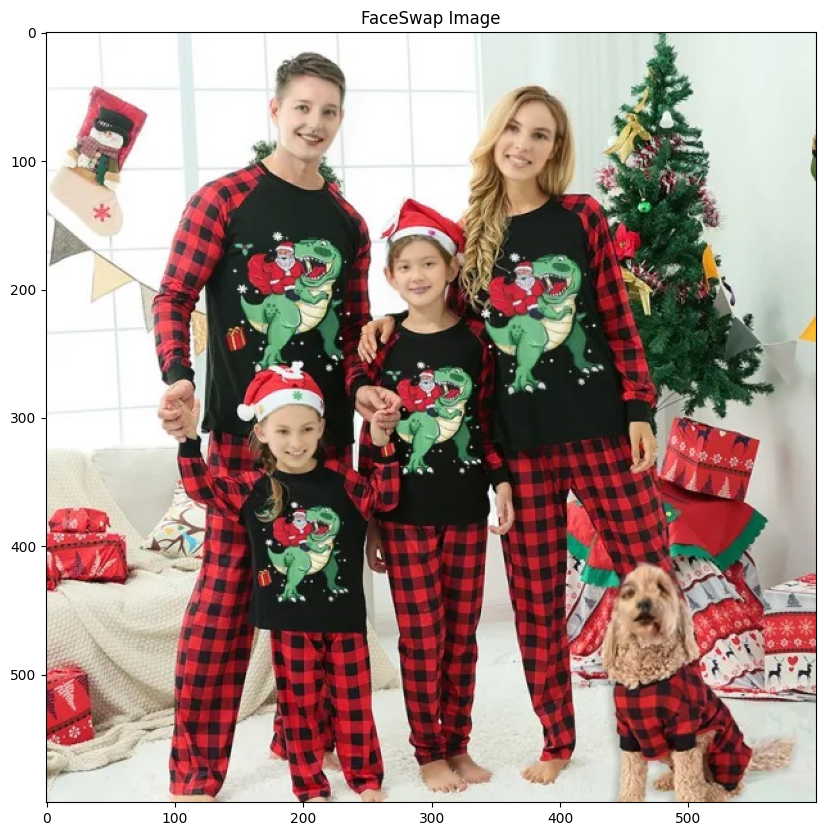

In [40]:
# Display the result image
plt.figure(figsize=(10, 10))

plt.imshow(res)
plt.axis('on')
plt.title('FaceSwap Image')

In [38]:
# swap each target face areas with corresponding source face and append new faces as a list
results = []
for idx, face in enumerate(faces):
    specific_src_face = src_face_representations[idx % len(src_face_representations)]
    _img, _ = swapper.get(img, face, specific_src_face, paste_back=False)
    results.append(_img)
results = np.concatenate(results, axis=1)
cv2.imwrite("mf_swapped2.jpg", results)

True

Text(0.5, 1.0, 'FaceSwap Image 2')

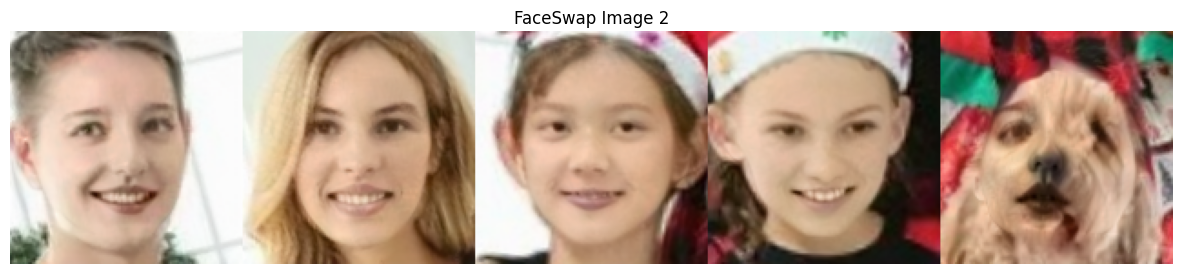

In [39]:
# Display the result image
plt.figure(figsize=(15, 5))
plt.plot(1, 5)
plt.imshow(results)
plt.axis('off')
plt.title('FaceSwap Image 2')

## Swap face

In [ ]:
import tempfile
import time

import onnxruntime
import gfpgan

In [ ]:


class Predictor():
    def setup(self):
        """Load the model into memory to make running multiple predictions efficient"""
        self.face_swapper = insightface.model_zoo.get_model('cache/inswapper_128.onnx', providers=onnxruntime.get_available_providers())
        self.face_enhancer = gfpgan.GFPGANer(model_path='cache/GFPGANv1.4.pth', upscale=1)
        self.face_analyser = FaceAnalysis(name='buffalo_l')
        self.face_analyser.prepare(ctx_id=0, det_size=(640, 640))

    def get_face(self, img_data):
        analysed = self.face_analyser.get(img_data)
        try:
            largest = max(analysed, key=lambda x: (x.bbox[2] - x.bbox[0]) * (x.bbox[3] - x.bbox[1]))
            return largest
        except:
            print("No face found")
            return None

    def predict(
        self,
        target_image: Path = Input(description="Target/base image"),
        swap_image: Path = Input(description="Swap/source image")
    ) -> Path:
        """Run a single prediction on the model"""
        try:
            frame = cv2.imread(str(target_image))
            face = self.get_face(frame)
            source_face = self.get_face(cv2.imread(str(swap_image)))
            try:
                print(frame.shape, face.shape, source_face.shape)
            except:
                print("printing shapes failed.")
            result = self.face_swapper.get(frame, face, source_face, paste_back=True)

            _, _, result = self.face_enhancer.enhance(
                result,
                paste_back=True
            )
            out_path = Path(tempfile.mkdtemp()) / f"{str(int(time.time()))}.jpg"
            cv2.imwrite(str(out_path), result)
            return out_path
        except Exception as e:
            print(f"{e}")
            return None